In [62]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ddint= pd.read_csv('/Users/mariusnwobi/Downloads/COMP ML/project/ddinter_downloads_code_A.csv')
# drug_acid= pd.read_csv('/Users/mariusnwobi/Downloads/COMP ML/project/drug_cids.csv')
# pchem= pd.read_csv('/Users/mariusnwobi/Downloads/COMP ML/project/pubchem_data.csv')

In [3]:
# not needed
ddint= ddint.drop(columns=['DDInterID_A','DDInterID_B'] ) 
# dropping the data with unknow 
ddint=ddint[ddint['Level']!='Unknown']
ddint

,Drug_A,Drug_B,Level
0,Naltrexone,Abacavir,Moderate
1,Abacavir,Orlistat,Moderate
2,Aluminum hydroxide,Dolutegravir,Major
3,Aprepitant,Dolutegravir,Minor
4,Attapulgite,Dolutegravir,Major
...,...,...,...
41595,Nalidixic acid,Zinc gluconate,Moderate
41596,Zinc gluconate,Naxitamab,Minor
41597,Oxytetracycline,Zinc gluconate,Moderate
41598,Sparfloxacin,Zinc gluconate,Moderate


# EDA

checking drug imbalance with the amount of drugs that we have

In [4]:
ddint['Drug_A'].value_counts()

Drug_A
Troglitazone                                400
Glimepiride                                 394
Morphine                                    377
Betamethasone                               372
Insulin human (inhalation, rapid acting)    369
                                           ... 
Levocetirizine                                1
Lefamulin                                     1
Ribociclib                                    1
Relugolix                                     1
Osilodrostat                                  1
Name: count, Length: 1388, dtype: int64

In [5]:
#Seeing amount of data that above average
avg=np.average(ddint['Drug_A'].value_counts())

ddint['Drug_A'].value_counts()[ddint['Drug_A'].value_counts()>avg]

Drug_A
Troglitazone                                400
Glimepiride                                 394
Morphine                                    377
Betamethasone                               372
Insulin human (inhalation, rapid acting)    369
                                           ... 
Telithromycin                                30
Epinephrine (ophthalmic)                     30
Nadolol                                      30
Butorphanol                                  30
Amlodipine                                   30
Name: count, Length: 365, dtype: int64

365 drugs have been documented more than 30 time compared to the 1023 who have less than 30 drug interactions( clear class imbalance in the amount of drug interactions might be better at predicting x drug vs y drug) 

<Axes: xlabel='Drug_A'>

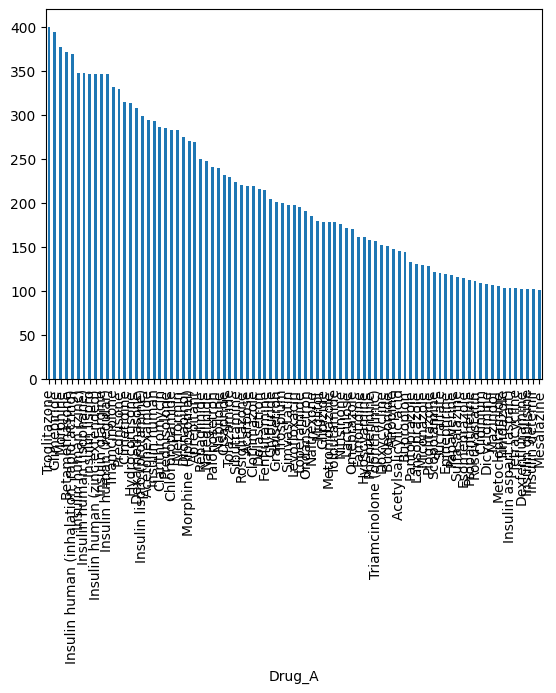

In [6]:
ddint['Drug_A'].value_counts()[ddint['Drug_A'].value_counts()>100].plot(kind='bar')

There is clear bias in the amount of drug to drug interactions, maybe we should filter to a certain amount of  required drug interactions to better look at our model and analyze it since this is clear class imbalance on this front also.

As a result if we model recklessly we might end up with a good model in reality but since it's poor with predicting other drugs, it'll decrease the overall accuracy making us feel as though our model is bad when it's actually good. 

# Checking the same thing but for classes 

In [7]:
ddint['Level'].value_counts()

Level
Moderate    33057
Major        4906
Minor        3637
Name: count, dtype: int64

Visual

Moderate is 79.4639423076923%, Moderate is 11.79326923076923%, Minor is 8.742788461538462%


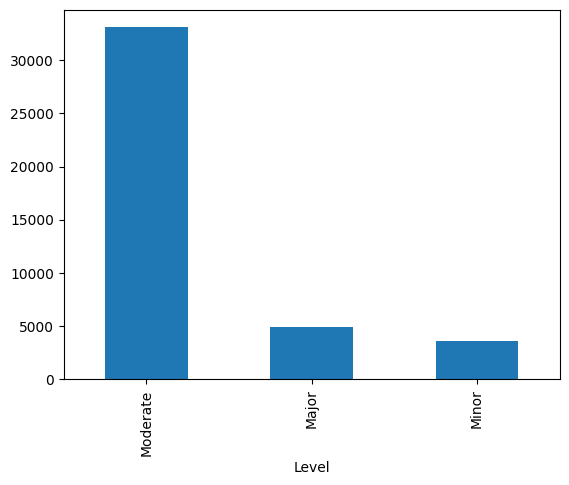

In [8]:
ddint['Level'].value_counts().plot(kind='bar')
print(f"Moderate is {(ddint['Level'].value_counts()[0]/ddint['Level'].value_counts().sum() )* 100}%, Moderate is {(ddint['Level'].value_counts()[1]/ddint['Level'].value_counts().sum() )* 100}%, Minor is {(ddint['Level'].value_counts()[2]/ddint['Level'].value_counts().sum() )* 100}%")

- might try to evenly sample data and split that way 
- try to augment data to improve amount of data for imbalanced class 

Sever class imbalance( restricted to using random forest or ensomble models or models that work well with dealing with class imbalances)

# Attempting Randomforest regression 

Preping the y data set

0 is Minor, 1 is Moderate, 2 in Major

In [9]:
for i in range(len(ddint['Level'])):
    if ddint['Level'][i]=='Moderate':
        ddint['Level'][i]=1
    if ddint['Level'][i]=='Minor':
        ddint['Level'][i]=0
    if ddint['Level'][i]=='Major':
        ddint['Level'][i]=2

 FOR TRAIN SET Class 1 (Moderate) is 79.48617788461539, For class 0 (Minor) is 8.662860576923077, For class 2 (Major) 11.850961538461538
 FOR TEST SET Class 1 (Moderate) is 79.375, For class 0 (Minor) is 9.0625, For class 2 (Major) 11.5625


Text(0.5, 1.0, 'distribution for TEST DATA')

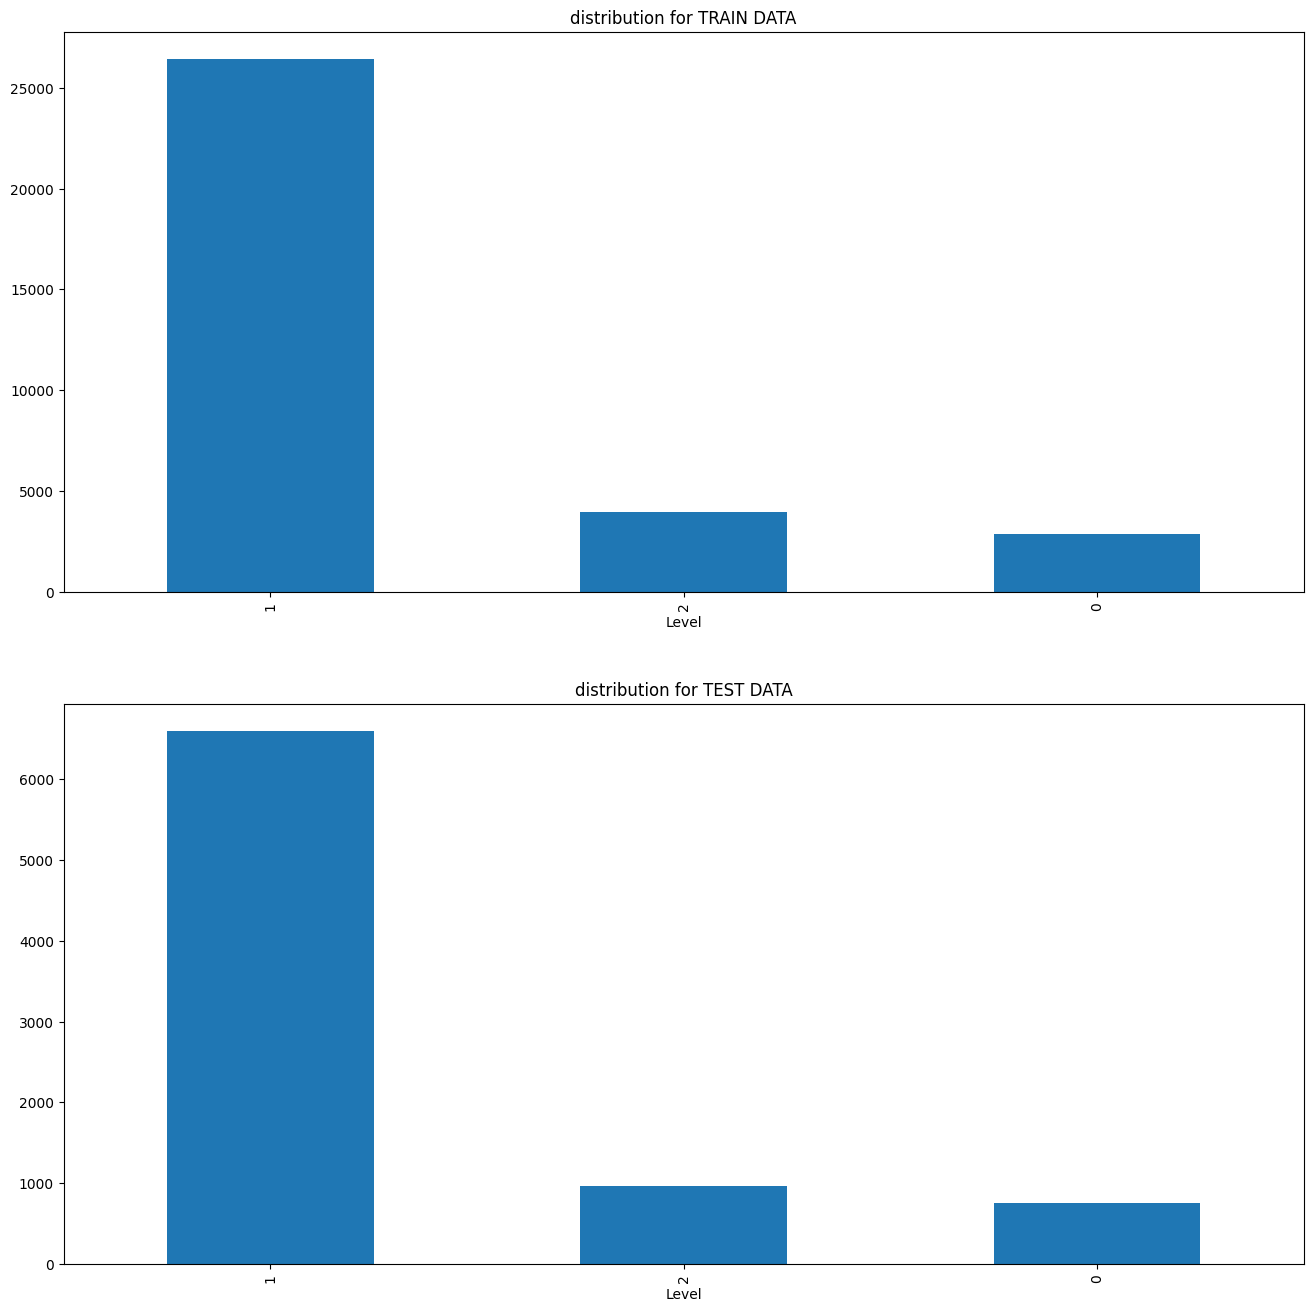

In [51]:
ddint['Level']=ddint['Level'].astype('Int64') # esential to make sure correct data type
# train test split
train_x,test_x,train_y,test_y= train_test_split(ddint.drop(columns=['Level']), ddint['Level'], test_size=.2)

# Visualizing the class distribution for train and test 
fig, axs = plt.subplots(2, figsize=(16, 16))

axs = axs.flatten()
train_y.value_counts().plot(kind='bar',ax=axs[0])
print( f' FOR TRAIN SET Class 1 (Moderate) is {(train_y.value_counts()[1]/train_y.value_counts().sum())* 100}, For class 0 (Minor) is {(train_y.value_counts()[0]/train_y.value_counts().sum())* 100}, For class 2 (Major) {(train_y.value_counts()[2]/train_y.value_counts().sum())* 100}')
axs[0].set_title('distribution for TRAIN DATA')

test_y.value_counts().plot(kind='bar',ax=axs[1])
print( f' FOR TEST SET Class 1 (Moderate) is {(test_y.value_counts()[1]/test_y.value_counts().sum())* 100}, For class 0 (Minor) is {(test_y.value_counts()[0]/test_y.value_counts().sum())* 100}, For class 2 (Major) {(test_y.value_counts()[2]/test_y.value_counts().sum())* 100}')
axs[1].set_title('distribution for TEST DATA')


# Attempting one hot encoding with X data set

In [58]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
oh_train = onehot_encoder.fit_transform(train_x).toarray()
oh_test = onehot_encoder.transform(test_x).toarray()

train_ox=pd.DataFrame(oh_train)
test_ox=pd.DataFrame(oh_test)


Checking to see if done correctly

In [12]:
train_ox

,0,1,2,3,4,5,6,7,8,9,...,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
train_ox.iloc[3,:].value_counts() # can slide from 0-> 33280 to check for sanity 

3
0.0    2820
1.0       2
Name: count, dtype: int64

In [ ]:
train_ox.sum().sum()
# can see that the sum is 33280 x 2

# Actual modeling for baseline with random forest 

In [54]:
model= RandomForestClassifier()
model.fit(train_ox,train_y)

ValueError: X has 2233 features, but RandomForestClassifier is expecting 2823 features as input.

              precision    recall  f1-score   support

         0.0       0.76      0.53      0.62       754
         1.0       0.88      0.95      0.91      6604
         2.0       0.66      0.41      0.51       962

    accuracy                           0.85      8320
   macro avg       0.77      0.63      0.68      8320
weighted avg       0.84      0.85      0.84      8320



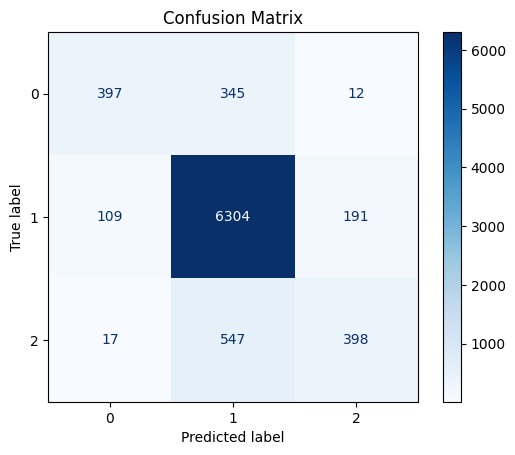

In [64]:
predictions=model.predict(test_ox)
print(metrics.classification_report(test_y,predictions))

d=ConfusionMatrixDisplay(confusion_matrix(test_y,predictions))
display_labels=(['Class 0', 'Class 1'])
d.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
plt.show()

In [65]:
metrics.accuracy_score(predictions,test_y)

0.8532451923076924

As expected doing great in predicting the class with the most data( as a result can see it's wrongly classifiying Minor and Major as Moderate)

Need to do something about this class imbalance and maybe look into how the drug differnce might be affecting this model


Later things cna be cv methods to prevent overfitting and trying different methods and then implementing Franco's feature engineering